In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [41]:
simulations_df = pd.read_csv('results/padoan_simulations_possession_exprate.csv')
display(simulations_df)

,simulation_id,Train_method,Test_method,A_is_random,B_is_random,A_wins,B_wins,draws,terminated_games,avg_match_length
0,1,vs_random,not_include_draws,False,True,8166,363,0,8529,11.724352
1,1,vs_random,include_draws,False,True,5933,103,10012,6036,7.865639
2,1,vs_belief,not_include_draws,False,False,4850,3639,0,8489,11.779597
3,1,vs_belief,not_include_draws,False,True,5170,541,0,5711,17.503414
4,1,vs_belief,not_include_draws,True,False,413,3073,0,3486,28.682731
...,...,...,...,...,...,...,...,...,...,...
75,10,vs_belief,not_include_draws,False,True,3371,549,0,3920,25.505612
76,10,vs_belief,not_include_draws,True,False,533,3158,0,3691,27.092929
77,10,vs_belief,include_draws,False,False,4665,3058,10062,7723,6.554707
78,10,vs_belief,include_draws,False,True,3420,171,10036,3591,7.938736


In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data, nan_policy='omit')  # standard error
    h = se * stats.t.ppf((1 + confidence) / 2., n-1) if n > 1 else 0
    return m, h
    
def get_configuration_stats(df):
    # Count stats
    for col in ['A_wins', 'B_wins', 'draws']:
        mean, hci = mean_confidence_interval(df[col])
        print(f"{col} -> Expected: {mean:.2f} ± {hci:.2f}")

    # Terminated games
    mean, hci = mean_confidence_interval(df['terminated_games'])
    print(f"Total games -> Expected: {mean:.2f} ± {hci:.2f}")

    # Average match length
    mean, hci = mean_confidence_interval(df['avg_match_length'])
    print(f"Average match length -> Expected: {mean:.2f} ± {hci:.2f}")

    # Win rates
    for name, ratio in [('A win rate', df['A_wins'] / df['terminated_games']),
                        ('B win rate', df['B_wins'] / df['terminated_games'])]:
        mean, hci = mean_confidence_interval(ratio * 100)
        print(f"{name} -> Expected: {mean:.2f} ± {hci:.2f} %")

In [43]:
def plot_stats(df):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Boxplot
    sns.boxplot(x='avg_match_length', hue='Test_method', data=df, ax=ax[0])

    # Compute mean outcomes grouped by Test_method
    mean_outcomes = df.groupby('Test_method')[['A_wins', 'draws', 'B_wins']].mean()

    # Normalize to percentages (row-wise)
    mean_outcomes_pct = mean_outcomes.div(mean_outcomes.sum(axis=1), axis=0) * 100

    # Barplot of percentages
    bar_plot = mean_outcomes_pct.plot(kind='bar', ax=ax[1])

    # Add percentage labels on top of bars
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height >= 0:
                ax[1].text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.1f}%',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

    # Add border to bars
    for bar in ax[1].patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    
    # Customize axes
    ax[0].set_title("Average Match Length by Test Method")
    ax[0].set_xlabel("Average Match Length")
    
    
    ax[1].set_xticklabels(mean_outcomes_pct.index, rotation=0)
    ax[1].set_ylabel("Percentage (%)")
    ax[1].set_title("Match Outcome % by Test Method")
    ax[1].legend(title="Outcome")

    plt.tight_layout()
    plt.close(fig)
    return fig


## Experiment 1: belief trained vs random

In [44]:
df = simulations_df.query("Train_method == 'vs_random' and A_is_random == False and B_is_random== True")
display(df.head())
print("-"*80)
print('>>Configuration without draws:')
get_configuration_stats(df.query("Test_method == 'not_include_draws'"))
print("-"*80)
print('>>Configuration with draws:')
get_configuration_stats(df.query("Test_method == 'include_draws'"))
print("-"*80)

,simulation_id,Train_method,Test_method,A_is_random,B_is_random,A_wins,B_wins,draws,terminated_games,avg_match_length
0,1,vs_random,not_include_draws,False,True,8166,363,0,8529,11.724352
1,1,vs_random,include_draws,False,True,5933,103,10012,6036,7.865639
8,2,vs_random,not_include_draws,False,True,8378,371,0,8749,11.429192
9,2,vs_random,include_draws,False,True,6204,85,9970,6289,7.774368
16,3,vs_random,not_include_draws,False,True,8526,554,0,9080,11.013216


--------------------------------------------------------------------------------
>>Configuration without draws:
A_wins -> Expected: 7895.70 ± 442.69
B_wins -> Expected: 455.70 ± 46.50
draws -> Expected: 0.00 ± 0.00
Total games -> Expected: 8351.40 ± 432.02
Average match length -> Expected: 12.03 ± 0.65
A win rate -> Expected: 94.51 ± 0.67 %
B win rate -> Expected: 5.49 ± 0.67 %
--------------------------------------------------------------------------------
>>Configuration with draws:
A_wins -> Expected: 6200.50 ± 534.78
B_wins -> Expected: 142.60 ± 23.29
draws -> Expected: 10012.70 ± 48.94
Total games -> Expected: 6343.10 ± 542.92
Average match length -> Expected: 7.44 ± 0.45
A win rate -> Expected: 97.74 ± 0.36 %
B win rate -> Expected: 2.26 ± 0.36 %
--------------------------------------------------------------------------------


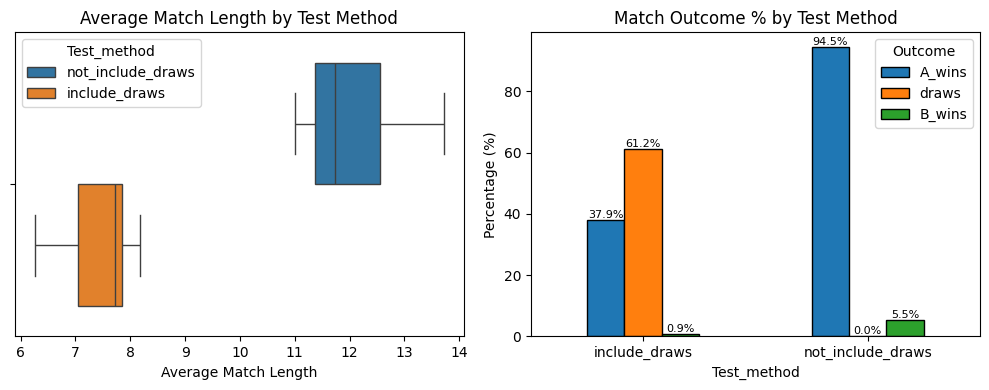

In [45]:
fig = plot_stats(df)
fig.savefig('results/plots/random vs dummy.png', dpi=300, bbox_inches='tight')
fig

## Experiment 2: belief trained vs belief

### A belief vs random

In [46]:
df = simulations_df.query("Train_method == 'vs_belief' and A_is_random == False and B_is_random== True")
display(df.head())
print("-"*80)
print('>>Configuration without draws:')
get_configuration_stats(df.query("Test_method == 'not_include_draws'"))
print("-"*80)
print('>>Configuration with draws:')
get_configuration_stats(df.query("Test_method == 'include_draws'"))
print("-"*80)

,simulation_id,Train_method,Test_method,A_is_random,B_is_random,A_wins,B_wins,draws,terminated_games,avg_match_length
3,1,vs_belief,not_include_draws,False,True,5170,541,0,5711,17.503414
6,1,vs_belief,include_draws,False,True,5220,176,9904,5396,6.872128
11,2,vs_belief,not_include_draws,False,True,3560,509,0,4069,24.562546
14,2,vs_belief,include_draws,False,True,2648,128,9857,2776,10.226945
19,3,vs_belief,not_include_draws,False,True,3675,491,0,4166,24.001920


--------------------------------------------------------------------------------
>>Configuration without draws:
A_wins -> Expected: 3959.10 ± 453.49
B_wins -> Expected: 463.10 ± 52.40
draws -> Expected: 0.00 ± 0.00
Total games -> Expected: 4422.20 ± 472.39
Average match length -> Expected: 23.03 ± 2.28
A win rate -> Expected: 89.42 ± 1.33 %
B win rate -> Expected: 10.58 ± 1.33 %
--------------------------------------------------------------------------------
>>Configuration with draws:
A_wins -> Expected: 3155.90 ± 713.23
B_wins -> Expected: 148.40 ± 16.08
draws -> Expected: 9967.50 ± 45.68
Total games -> Expected: 3304.30 ± 720.17
Average match length -> Expected: 9.72 ± 1.31
A win rate -> Expected: 95.21 ± 1.02 %
B win rate -> Expected: 4.79 ± 1.02 %
--------------------------------------------------------------------------------


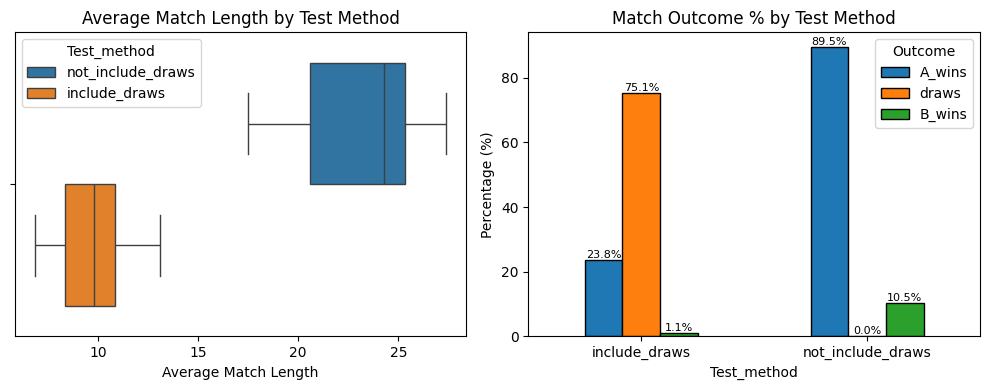

In [47]:
fig = plot_stats(df)
fig.savefig('results/plots/belief_vs_dummy.png', dpi=300, bbox_inches='tight')
fig

### B belief vs random

In [48]:
df = simulations_df.query("Train_method == 'vs_belief' and A_is_random == True and B_is_random== False")
display(df.head())
print("-"*80)
print('>>Configuration without draws:')
get_configuration_stats(df.query("Test_method == 'not_include_draws'"))
print("-"*80)
print('>>Configuration with draws:')
get_configuration_stats(df.query("Test_method == 'include_draws'"))
print("-"*80)

,simulation_id,Train_method,Test_method,A_is_random,B_is_random,A_wins,B_wins,draws,terminated_games,avg_match_length
4,1,vs_belief,not_include_draws,True,False,413,3073,0,3486,28.682731
7,1,vs_belief,include_draws,True,False,139,1766,9960,1905,12.711811
12,2,vs_belief,not_include_draws,True,False,525,3611,0,4136,24.146277
15,2,vs_belief,include_draws,True,False,191,3301,9944,3492,8.601375
20,3,vs_belief,not_include_draws,True,False,444,3142,0,3586,27.880368


--------------------------------------------------------------------------------
>>Configuration without draws:
A_wins -> Expected: 458.60 ± 34.15
B_wins -> Expected: 3365.70 ± 378.08
draws -> Expected: 0.00 ± 0.00
Total games -> Expected: 3824.30 ± 390.25
Average match length -> Expected: 26.57 ± 2.40
A win rate -> Expected: 12.12 ± 1.08 %
B win rate -> Expected: 87.88 ± 1.08 %
--------------------------------------------------------------------------------
>>Configuration with draws:
A_wins -> Expected: 161.60 ± 13.81
B_wins -> Expected: 2420.30 ± 507.38
draws -> Expected: 10025.70 ± 86.02
Total games -> Expected: 2581.90 ± 513.34
Average match length -> Expected: 10.79 ± 1.03
A win rate -> Expected: 6.61 ± 1.18 %
B win rate -> Expected: 93.39 ± 1.18 %
--------------------------------------------------------------------------------


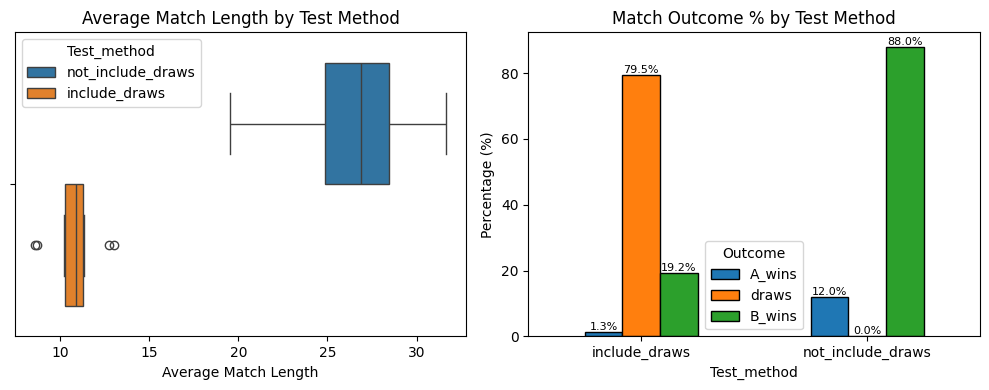

In [49]:
fig = plot_stats(df)
fig.savefig('results/plots/dummy_vs_belief.png', dpi=300, bbox_inches='tight')
fig

### A belief vs B belief

In [50]:
df = simulations_df.query("Train_method == 'vs_belief' and A_is_random == False and B_is_random== False")
display(df.head())
print("-"*80)
print('>>Configuration without draws:')
get_configuration_stats(df.query("Test_method == 'not_include_draws'"))
print("-"*80)
print('>>Configuration with draws:')
get_configuration_stats(df.query("Test_method == 'include_draws'"))
print("-"*80)

,simulation_id,Train_method,Test_method,A_is_random,B_is_random,A_wins,B_wins,draws,terminated_games,avg_match_length
2,1,vs_belief,not_include_draws,False,False,4850,3639,0,8489,11.779597
5,1,vs_belief,include_draws,False,False,3400,1977,9891,5377,8.935466
10,2,vs_belief,not_include_draws,False,False,5799,5444,0,11243,8.894067
13,2,vs_belief,include_draws,False,False,4859,4527,9890,9386,5.895270
18,3,vs_belief,not_include_draws,False,False,4303,4401,0,8704,11.488396


--------------------------------------------------------------------------------
>>Configuration without draws:
A_wins -> Expected: 4542.50 ± 715.59
B_wins -> Expected: 3912.10 ± 564.62
draws -> Expected: 0.00 ± 0.00
Total games -> Expected: 8454.60 ± 1071.30
Average match length -> Expected: 12.20 ± 1.69
A win rate -> Expected: 53.51 ± 4.08 %
B win rate -> Expected: 46.49 ± 4.08 %
--------------------------------------------------------------------------------
>>Configuration with draws:
A_wins -> Expected: 3334.20 ± 820.28
B_wins -> Expected: 2552.30 ± 758.16
draws -> Expected: 9987.40 ± 78.20
Total games -> Expected: 5886.50 ± 1276.90
Average match length -> Expected: 8.42 ± 1.17
A win rate -> Expected: 56.87 ± 7.67 %
B win rate -> Expected: 43.13 ± 7.67 %
--------------------------------------------------------------------------------


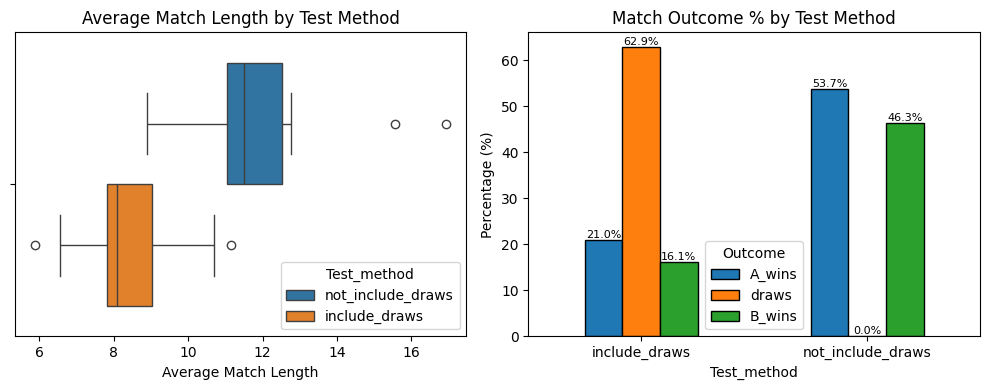

In [51]:
fig = plot_stats(df)
fig.savefig('results/plots/belief_vs_belief.png', dpi=300, bbox_inches='tight')
fig

## Bonus for presentation

Explore the distribution over actions given a state

In [3]:
from FootballRL import Environment,Agent
from tqdm import trange
import pickle

In [1]:
def train_agents(agent_A, agent_B, n_episodes=1000000):
    tbar = trange(n_episodes, desc="Training Progress", unit="Episode")
    for i in tbar:
        old_state = (agent_A.environment.a_state, agent_A.environment.b_state)
        a1_action = agent_A.choose_action()
        a2_action = agent_B.choose_action()
        old_possession = agent_A.environment.possession_a
        
        agent_A.environment.next_turn((a1_action, a2_action))

        agent_A.update_agent(old_state, old_possession, (a1_action, a2_action))
        agent_B.update_agent(old_state, old_possession, (a1_action, a2_action))
        
        tbar.set_postfix(
            {'Home wins': agent_A.environment.won_games_A,
            'Played games': agent_A.environment.terminated_games,
            'Home wins %': 100*(agent_A.environment.won_games_A / agent_A.environment.terminated_games) if agent_A.environment.terminated_games > 0 else 0}
	    )   

    print(f"Training completed after {n_episodes} episodes.")
    print(f"TRAIN: Home agent won {agent_A.environment.won_games_A} out of {agent_A.environment.terminated_games} games.")
    print(f"TRAIN: Away agent won {agent_B.environment.won_games_B} out of {agent_B.environment.terminated_games} games.")
    return agent_A, agent_B

In [ ]:
environment = Environment()
agent_A = Agent(environment, random_policy=False,is_A = True)
agent_B = Agent(environment, random_policy=False,is_A = False)

agent_A, agent_B = train_agents(agent_A, agent_B, n_episodes=1000000)

In [67]:
# # Here I will fix a state and check both the policy of an agent both the belief of the opponent (and see if there is a mismatch)
environment.reset()
environment.a_state = (2,0)
environment.b_state = (3,1)
environment.possession_a = True

In [68]:
print(environment)

+-----+---+---+---+---+
|  0  | 0 | 0 | 0 | 0 |
+-----+---+---+---+---+
|  0  | 0 | 0 | 0 | 0 |
+-----+---+---+---+---+
| (A) | 0 | 0 | 0 | 0 |
+-----+---+---+---+---+
|  0  | B | 0 | 0 | 0 |
+-----+---+---+---+---+


Let's inspect the probability distribution over A actions

Correct, if A goes West he scores!

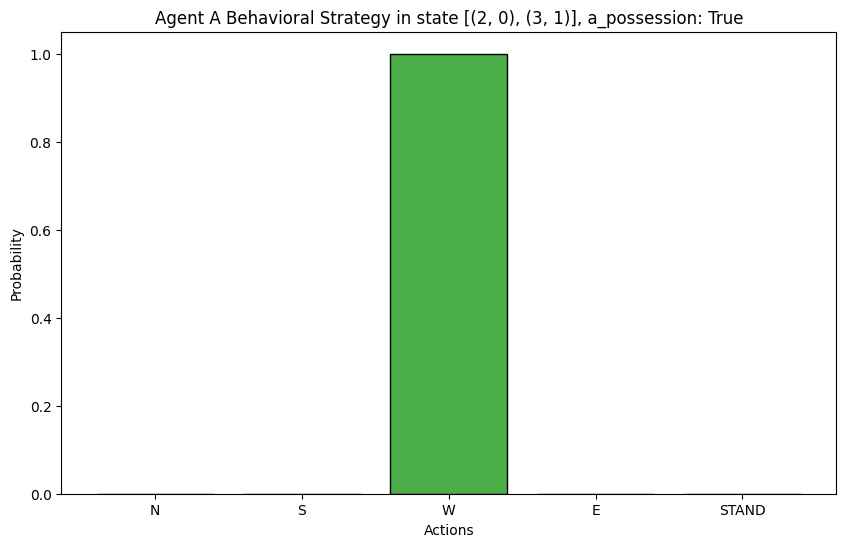

In [85]:
s_a_idx, s_b_idx, p_idx = agent_A._get_state_indices(str(environment.a_state), str(environment.b_state),agent_A.environment.possession_a)
A_pi = agent_A.pi[s_a_idx, s_b_idx, p_idx]

plt.figure(figsize=(10, 6))
plt.bar(
    x=range(len(agent_A.action_idx)),
    height=A_pi,
    tick_label=agent_A.action_idx.keys(),
    color=sns.color_palette("Set1", n_colors=len(agent_A.action_idx)),
    edgecolor='black'
)
plt.xticks(ticks=range(len(agent_A.action_idx)), labels=agent_A.action_idx.keys());
plt.xlabel("Actions")
plt.ylabel("Probability")
plt.title(f"Agent A Behavioral Strategy in state [{environment.a_state}, {environment.b_state}], a_possession: {environment.possession_a}")
plt.savefig("results/plots/A_strategy.png", dpi=300, bbox_inches='tight')

Let's also inspect belief of B about A's action

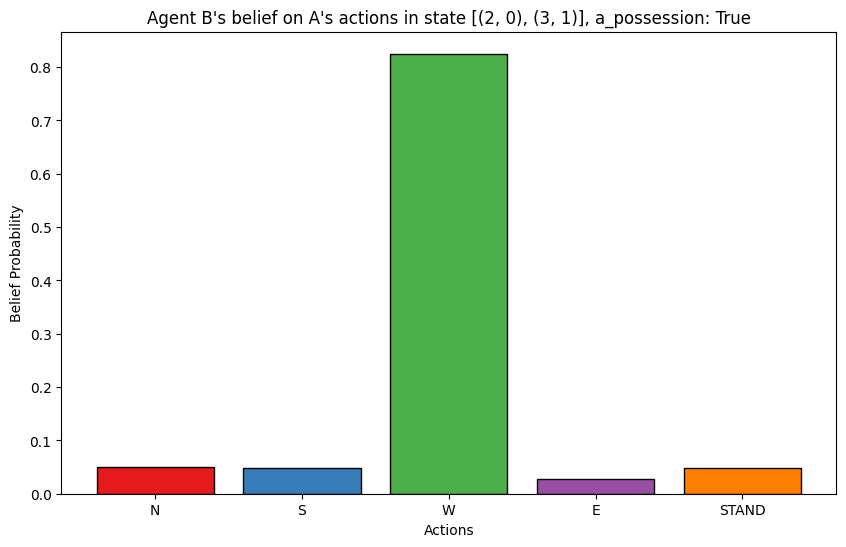

In [ ]:
belief_B = agent_B.belief_prob[s_a_idx, s_b_idx, p_idx]
plt.figure(figsize=(10, 6))
plt.bar(
    x=range(len(agent_A.action_idx)),
    height=belief_B,
    tick_label=agent_A.action_idx.keys(),
    color=sns.color_palette("Set1", n_colors=len(agent_A.action_idx)),
    edgecolor='black'
)
plt.xticks(ticks=range(len(agent_A.action_idx)), labels=agent_A.action_idx.keys());
plt.xlabel("Actions")
plt.ylabel("Belief Probability")
plt.title(f"Agent B's belief on A's actions in state [{environment.a_state}, {environment.b_state}], a_possession: {environment.possession_a}")
plt.savefig("results/plots/B_belief.png", dpi=300, bbox_inches='tight')